In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from gen_disc_networks import Generator, Discriminator
from customDataSet import CustomDataset

In [6]:
import zipfile

# Download zip file of pizza_steak images
!wget https://drive.google.com/file/d/1kHyRJ_NQRdK37KNfO2jdh2tzJyagNsyf/view?usp=drive_link
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-05-18 13:59:21--  https://drive.google.com/file/d/1kHyRJ_NQRdK37KNfO2jdh2tzJyagNsyf/view?usp=drive_link
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving drive.google.com (drive.google.com)... 2a00:1450:4001:813::200e, 142.250.185.238
Connecting to drive.google.com (drive.google.com)|2a00:1450:4001:813::200e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=drive_link.1’

view?usp=drive_link     [ <=>                ]  83.14K  --.-KB/s    in 0.05s   

2024-05-18 13:59:22 (1.62 MB/s) - ‘view?usp=drive_link.1’ saved [85138]



In [2]:
noise_dim = 100
G = Generator(noise_dim)
D = Discriminator()
#G.get_submodule
print("Generator summary")
summary(G, [(1, 256, 256), (noise_dim, 1, 1)])

print("Discriminator summary")
summary(D, (2, 256, 256))
#for parameter in G.parameters():
#    print(parameter)

Generator summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1        [-1, 512, 259, 259]         827,392
       BatchNorm2d-2        [-1, 512, 259, 259]           1,024
              ReLU-3        [-1, 512, 259, 259]               0
   ConvTranspose2d-4        [-1, 256, 518, 518]       2,097,152
       BatchNorm2d-5        [-1, 256, 518, 518]             512
              ReLU-6        [-1, 256, 518, 518]               0
   ConvTranspose2d-7      [-1, 128, 1036, 1036]         524,288
       BatchNorm2d-8      [-1, 128, 1036, 1036]             256
              ReLU-9      [-1, 128, 1036, 1036]               0
  ConvTranspose2d-10       [-1, 64, 2072, 2072]         131,072
      BatchNorm2d-11       [-1, 64, 2072, 2072]             128
             ReLU-12       [-1, 64, 2072, 2072]               0
  ConvTranspose2d-13        [-1, 1, 4144, 4144]           1,024
             Tanh-14 

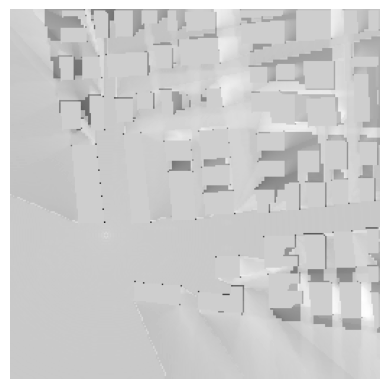

In [3]:

batch_size = 64
pixel_size = 256
# Create dataset instance
transform = transforms.Compose([
    transforms.Resize((pixel_size, pixel_size)),  # Resize to pixel_size x pixel_size
    transforms.ToTensor()  # Convert to tensor
])
dataset_dpm_path = 'dataset/DPM/'
dataset_irt_path = 'dataset/IRT2/'

dataset = CustomDataset(dataset_dpm_path, dataset_irt_path, transform=transform)

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(data_loader.dataset)

# Choose a random index
random_index = random.randint(0, len(dataset) - 1)
# Get the image at the random index

image_dpm, image_irt = dataset[random_index]

# Convert tensor to numpy array and remove batch dimension
image_dpm_np = image_dpm.squeeze().numpy()
image_irt_np = image_irt.squeeze().numpy()

# Plot the image

plt.imshow(image_irt_np - image_dpm_np, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
# Assuming you have the Generator and Discriminator classes defined

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Hyperparameters
batch_size = 64
noise_dim = 100
lr = 0.0002
num_epochs = 10


# Initialize models
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(data_loader)):
        # Unpack the batch
        simulated_map, measured_map = batch

        # Move tensors to device
        simulated_map = simulated_map.to(device)
        measured_map = measured_map.to(device)

        ############################
        # Train discriminator
        ############################
        d_optimizer.zero_grad()

        real_labels = torch.ones(batch_size, 1, device=device)
# Concatenate the simulated map and measured map along the channel dimension
        real_inputs = torch.cat((simulated_map, measured_map), dim=1)
        real_outputs = discriminator(real_inputs)
        d_loss_real = criterion(real_outputs.squeeze(), real_labels.squeeze())
        d_loss_real.backward()



        # Train with fake data
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(simulated_map, noise)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.step()

        ############################
        # Train generator
        ############################
        g_optimizer.zero_grad()

        # Generate fake images
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(simulated_map, noise)
        
        # Train generator with discriminator feedback
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        ############################
        # Print losses
        ############################
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")


cpu


  0%|                                    | 0/2 [00:00<?, ?it/s]

In [ ]:
print(real_labels.squeeze().size())
real_outputs.squeeze().size()